### <center> Serial Shearlet Decomposition and Reconstruction </center>

In [1]:
# Clone the libraris
#Pkg.clone("https://github.com/arsenal9971/Shearlab.jl.git")

In [2]:
# Loard the Pkg
# push!(LOAD_PATH,pwd()*"/../../src") 
# import Shearlab
using Shearlab
using PyPlot
#reload("Shearlab")

In [3]:
# Read Data
n = 512;
# The path of the image
name = "../../data_samples/bessyii.bmp";
data = Shearlab.load_image(name, n);
#Rescale image in [0,1] summing the 3 arrays in the RGB format
data = Shearlab.rescale(sum(data,3));

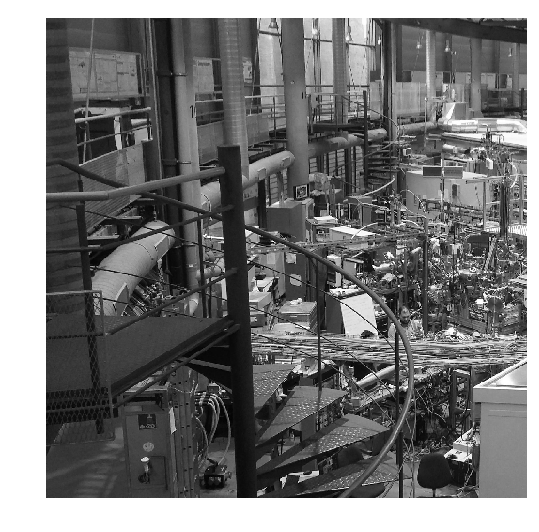

In [4]:
# Reduce one dimension 
data = data[:,:,1];
Shearlab.imageplot(data);

#### Decomposition.

In [5]:
nScales = 4;

In [6]:
# Prepare serial processing
preparedSerial = Shearlab.prepareserial2D(data, nScales);

In [7]:
# Store variables
Xfreq = preparedSerial.Xfreq;
Xrec = preparedSerial.Xrec;
preparedFilters = preparedSerial.preparedFilters;
dualFrameWeightsCurr = preparedSerial.dualFrameWeightsCurr;
shearletIdxs = preparedSerial.shearletIdxs;

In [8]:
for j in 1:size(shearletIdxs,1)
    shearletIdx = shearletIdxs[j,:]';
    
    # Shearlet decomposition
    shearletserial2D = Shearlab.sheardecserial2D(Xfreq, shearletIdx, preparedFilters,
                                                 dualFrameWeightsCurr);
    coefficients = shearletserial2D.coeffs;
    shearlet = shearletserial2D.shearlet;
    dualFrameWeightsCurr = shearletserial2D.dualFrameWeightsNew;
    RMS = shearletserial2D.RMS;
end      

#### Reconstruction

In [9]:
for j in 1:size(shearletIdxs,1)
    shearletIdx = shearletIdxs[j,:]';
    
    #shearlet decomposition
    shearletserial2D = Shearlab.sheardecserial2D(Xfreq, shearletIdx, preparedFilters,
                                                  dualFrameWeightsCurr);
    # Save variables
    coefficients = shearletserial2D.coeffs;
    shearlet = shearletserial2D.shearlet;
    dualFrameWeightsCurr = shearletserial2D.dualFrameWeightsNew;
    
    # Processing
    Xrec = Shearlab.shearrecserial2D(coefficients, shearlet, Xrec);
end

In [10]:
# Final Reconstruction
reconstruction = Shearlab.finishserial2D(Xrec,dualFrameWeightsCurr);

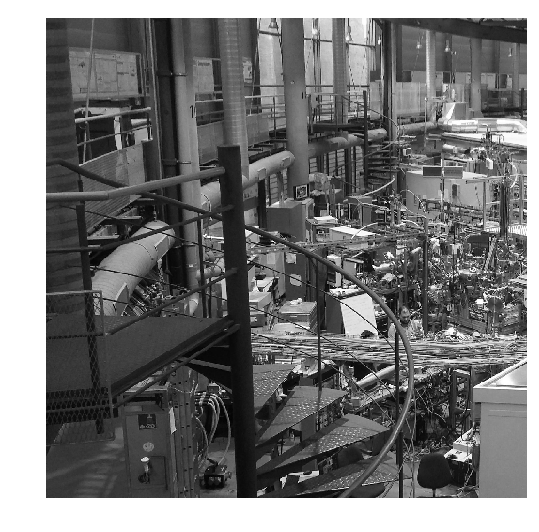

In [11]:
# Image
Shearlab.imageplot(real(reconstruction));